## Part1 Three layer network (60 points):

<p>
Create a notebook called threelayer.ipynb.
Extend the fully-connected two layer perceptron shown in class for the regression
problem by one more layer to have two hidden layers.
For this, take a long look at the derivation of the backpropagation. As you can see,
the derivation of the internal derivatives is always the same, no matter the number
of hidden layers.
Armed with this knowledge, it should be easy to extend the different functions in
the notebook.
The create_model function should now of course receive a list of values for the
number of hidden_nodes in each layer - in addition, please extend the functionality,
so that I can pass the activation function type as a string already here:
</p>

<br/>

```python
def create_model(X, hidden_nodes, output_dim = 2, activation_function = 'relu') :
    return
```

<p>
forward, calculate_loss, backprop should of course be extended
accordingly to deal with the added number of layers and the activation function
choice.
Next, do a series of tests for the x^2+y^2+1 function using a learning rate of 0.001, a
tolerance threshold of 0.0001, maximum iterations of 100,000, NO sgd, and NO
regularization, and a “relu” function, comparing the “old” two-layer version with
your “new” three-layer version as follows:
- take 8 neurons for the two-layer version and 4 + 4 neurons for the three-layer
version, and run each network 20 times, recording the loss and the number
of iterations it needs
- repeat this with 16 neurons for the two-layer version and 8+8 neurons for the
three-layer version and 20 runs each
- which network architecture converges “better” (earlier? lower error?). Plot
the results nicely in one graph for errors and in another for number of
iterations and comment on the results.
</p>

In [1]:
# numpy, matplotlib imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# activation functions
def relu(X):
    return np.maximum(X, 0)

def relu_derivative(X):
    return 1. * (X > 0)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return 1.-tanh(X)**2

def logistic(X):
    return 1./(1. + np.exp(-X))

def logistic_derivative(X):
    return logistic(X)*(1. - logistic(X))

# Activation functions mapping
activation_functions = {
    'relu': relu,
    'tanh': tanh,
    'logistic': logistic
}

# Activation functions derivatives mapping
activation_derivatives = {
    'relu': relu_derivative,
    'tanh': tanh_derivative,
    'logistic': logistic_derivative
}

In [3]:
# create a two-layer neural network
def old_create_model(X, hidden_nodes, output_dim = 2):
    # this will hold a dictionary of layers
    model = {}
    
    # input dimensionality
    input_dim = X.shape[1]
    
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes) / np.sqrt(input_dim)
    
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes))

    # second set of weights from hidden layer 1 to output
    model['W2'] = np.random.randn(hidden_nodes, output_dim) / np.sqrt(hidden_nodes)
    
    # set of biases
    model['b2'] = np.zeros((1, output_dim))
    
    return model

# defines the forward pass given a model and data
def old_feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # first layer
    z1 = x.dot(W1) + b1

    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = relu(z1)

    # second layer
    z2 = a1.dot(W2) + b2

    # no activation function as this is simply a linear layer!!
    out = z2
    return z1, a1, z2, out

# define the regression loss
def old_calculate_loss(model,X,y):
    num_examples = X.shape[0]
    
    # what are the current predictions
    z1, a1, z2, out = old_feed_forward(model, X)

    # calculate MSE loss
    loss = 0.5 * np.sum((out - y) ** 2)

    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def old_backprop(X,y,model,z1,a1,z2,output):
    num_examples = X.shape[0]
    
    # derivative of loss function
    delta3 = (output-y)/num_examples
    
    # multiply this by activation outputs of hidden layer
    dW2 = (a1.T).dot(delta3)
    
    # and over all neurons
    db2 = np.sum(delta3, axis=0, keepdims=True)

    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T) * logistic_derivative(a1) #if logistic
    #delta2 = delta3.dot(model['W2'].T) * tanh_derivative(a1) #if tanh
    delta2 = delta3.dot(model['W2'].T) * relu_derivative(a1) #if ReLU

    # multiply by input data
    dW1 = np.dot(X.T, delta2)
    
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)

    return dW1, dW2, db1, db2

# simple training loop
def old_train(model, X, y, num_passes=100000, learning_rate = 0.001, tolerance=0.0001):
    # variable that checks whether we break iteration
    done = False

    # keeping track of losses
    previous_loss = float('inf')
    
    losses = []

    # iteration counter
    i = 0
    
    while not done:
        # get predictions
        z1,a1,z2,output = old_feed_forward(model, X)
        
        # feed this into backprop
        dW1, dW2, db1, db2 = old_backprop(X, y, model, z1, a1, z2, output)

        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2

        loss = old_calculate_loss(model, X, y)
        if i % 1000 == 0:
            losses.append(loss)
            print("two-layer Loss after iteration {}: {}".format(i, loss))
            if np.abs((previous_loss - loss) / previous_loss) < 0.0001:
                print(np.abs((previous_loss - loss) / previous_loss), previous_loss, loss)
                done = True
            previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True
            
    return model, losses, i

In [4]:
# create a three-layer neural network
def create_model(X, hidden_nodes, output_dim = 2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    
    #save activation function to model
    model['activation_function'] = activation_function
    
    # input dimensionality
    input_dim = X.shape[1]
    
    # [i -> 1]weights and biases from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes[0]) / np.sqrt(input_dim)
    model['b1'] = np.zeros((1, hidden_nodes[0]))
    
    # [1 -> 2]weights and biases  from  hidden layer 1 to hidden layer 2
    model['W2'] = np.random.randn(hidden_nodes[0], hidden_nodes[1]) / np.sqrt(hidden_nodes[0])
    model['b2'] = np.zeros((1, hidden_nodes[1]))

    # [2 -> o]weights and biases from hidden layer 2 to output
    model['W3'] = np.random.randn(hidden_nodes[1], output_dim) / np.sqrt(hidden_nodes[1])
    model['b3'] = np.zeros((1, output_dim))
    
    return model

# defines the forward pass given a model and data
def feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # get activation function
    act_func = activation_functions.get(model['activation_function'])
    
    # first layer
    z1 = x.dot(W1) + b1
    a1 = relu(z1)

    # second layer
    z2 = a1.dot(W2) + b2
    a2 = relu(z2)
    
    # third layer
    z3 = a2.dot(W3) + b3
    out = z3
    
    return z1, a1, z2, a2, z3, out
    
# define the regression loss
def calculate_loss(model,X,y):
    num_examples = X.shape[0]
    # what are the current predictions
    z1, a1, z2, a2, z3, out = feed_forward(model, X)

    # calculate MSE loss
    loss = 0.5 * np.sum((out - y) ** 2)

    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,model,z1,a1,z2,a2,z3,output):
    num_examples = X.shape[0]
    
    # get activation function derivate
    act_func_derivative = activation_derivatives.get(model['activation_function'])

    # Derivative of loss function for output layer
    delta4 = (output - y) / num_examples

    # multiply this by activation outputs of hidden layer
    dW3 = a2.T.dot(delta4)

    # and over all neurons
    db3 = np.sum(delta4, axis=0, keepdims=True)

    # derivative of activation function
    delta3 = delta4.dot(model['W3'].T) * relu_derivative(a2)

    # multiply this by hidden layer outputs
    dW2 = a1.T.dot(delta3)

    # and over all neurons
    db2 = np.sum(delta3, axis=0, keepdims=True)

    # derivative of activation function
    delta2 = delta3.dot(model['W2'].T) * relu_derivative(a1)

    # multiply by input data
    dW1 = X.T.dot(delta2)

    # and over all neurons
    db1 = np.sum(delta2, axis=0)

    return dW1, dW2, dW3, db1, db2, db3

# simple training loop
def train(model, X, y, num_passes=100000, learning_rate = 0.001, tolerance = 0.0001):
    # variable that checks whether we break iteration
    done = False

    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while not done:
        # get predictions
        z1, a1, z2, a2, z3, output = feed_forward(model, X)

        # feed this into backprop
        dW1, dW2, dW3, db1, db2, db3 = backprop(X, y, model, z1, a1, z2, a2, z3, output)
        
        # Update weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        model['W3'] -= learning_rate * dW3
        model['b3'] -= learning_rate * db3

        # calculate loss
        loss = calculate_loss(model, X, y)

        # print loss per 1000 iterations
        if i % 1000 == 0:
            losses.append(loss)
            print("three-layer Loss after iteration {}: {}".format(i, loss))

        # Check for convergence
            if np.abs((previous_loss - loss) / previous_loss) < 0.0001:
                print(np.abs((previous_loss - loss) / previous_loss), previous_loss, loss)
                done = True
            previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True
    return model, losses, i

In [5]:
import time

numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0

X = np.empty((0, 2))
y = np.empty((0, 1))

for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X = np.vstack((X, [xs[r], ys[c]]))
        y = np.vstack((y, xs[r]**2 + ys[c]**2 + 1))

# training set size
num_examples = len(X)
# input layer dimensionality
nn_input_dim = 2
# output layer dimensionality
nn_output_dim = 1
# learning rate for gradient descent
learning_rate = 0.001

# Parameters
num_runs = 20
tolerance = 0.0001
max_iterations = 100000

# Data structures to store results
results_old = {"8": {"losses": [], "iterations": []}}
results_new = {"4+4": {"losses": [], "iterations": []}}

# keeping time
start_time = time.time()

# Test the old (2-layer) network with 8 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 8, 1)
    model_old, losses, iterations = old_train(model_old, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_old["8"]["losses"].append(losses[-1])
    results_old["8"]["iterations"].append(iterations)

# Test the new (3-layer) network with 4+4 neurons
for _ in range(num_runs):
    model_new = create_model(X, [4,4], 1)
    model_new, losses, iterations = train(model_new, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_new["4+4"]["losses"].append(losses[-1])
    results_new["4+4"]["iterations"].append(iterations)

print(results_old, results_new)

# Update data structures to store results for the next configurations
results_old["16"] = {"losses": [], "iterations": []}
results_new["8+8"] = {"losses": [], "iterations": []}

# Test the old (2-layer) network with 16 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 16, 1)
    model_old, losses, iterations = old_train(model_old, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_old["16"]["losses"].append(losses[-1])
    results_old["16"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

# Test the new (3-layer) network with 8+8 neurons
for _ in range(num_runs):
    model_new = create_model(X, [8, 8], 1)
    model_new, losses, iterations = train(model_new, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_new["8+8"]["losses"].append(losses[-1])
    results_new["8+8"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

print(results_old, results_new)

'''
# Update data structures to store results for the next configurations
results_old["32"] = {"losses": [], "iterations": []}
results_new["16+16"] = {"losses": [], "iterations": []}

# Test the old (2-layer) network with 32 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 32, 1)
    _, losses, iterations = old_train(model_old, X, y, 
                                      num_passes=max_iterations, 
                                      learning_rate=learning_rate, 
                                      tolerance=tolerance)
    results_old["32"]["losses"].append(losses[-1])
    results_old["32"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

# Test the new (3-layer) network with 16+16 neurons
for _ in range(num_runs):
    model_new = create_model(X, [16, 16], 1)
    _, losses, iterations = train(model_new, X, y, 
                                  num_passes=max_iterations, 
                                  learning_rate=learning_rate, 
                                  tolerance=tolerance)
    results_new["16+16"]["losses"].append(losses[-1])
    results_new["16+16"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

print(results_old, results_new)
'''

print("--- %s seconds ---" % (time.time() - start_time))

two-layer Loss after iteration 0: 1490.272644561784
two-layer Loss after iteration 1000: 26.010865033660018


C:\Users\jws\AppData\Local\Temp\ipykernel_20816\3437914713.py:112: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < 0.0001:


two-layer Loss after iteration 2000: 10.180591186855196
two-layer Loss after iteration 3000: 7.449825316105285
two-layer Loss after iteration 4000: 6.70171778196685
two-layer Loss after iteration 5000: 5.3174511435279666
two-layer Loss after iteration 6000: 4.55254909704113
two-layer Loss after iteration 7000: 4.281049548168682
two-layer Loss after iteration 8000: 4.159493104038956
two-layer Loss after iteration 9000: 4.070863817984685
two-layer Loss after iteration 10000: 3.9419456984414896
two-layer Loss after iteration 11000: 3.8332776669385296
two-layer Loss after iteration 12000: 3.7586541151312507
two-layer Loss after iteration 13000: 3.6927010155404627
two-layer Loss after iteration 14000: 3.645233606204771
two-layer Loss after iteration 15000: 3.6092909044644435
two-layer Loss after iteration 16000: 3.5840704492466164
two-layer Loss after iteration 17000: 3.560163105418273
two-layer Loss after iteration 18000: 3.5442282082670875
two-layer Loss after iteration 19000: 3.520773862

C:\Users\jws\AppData\Local\Temp\ipykernel_20816\2957246329.py:131: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < 0.0001:


three-layer Loss after iteration 2000: 29.20447985964855
three-layer Loss after iteration 3000: 26.417472327763996
three-layer Loss after iteration 4000: 25.50246121302901
three-layer Loss after iteration 5000: 25.421519739660848
three-layer Loss after iteration 6000: 25.11705531279063
three-layer Loss after iteration 7000: 25.0664972361905
three-layer Loss after iteration 8000: 24.037160521203713
three-layer Loss after iteration 9000: 22.451822780105964
three-layer Loss after iteration 10000: 22.672401560988387
three-layer Loss after iteration 11000: 22.524288480014736
three-layer Loss after iteration 12000: 21.75109601800643
three-layer Loss after iteration 13000: 20.82045535730079
three-layer Loss after iteration 14000: 20.64432327509546
three-layer Loss after iteration 15000: 19.87236838225023
three-layer Loss after iteration 16000: 19.078703100674527
three-layer Loss after iteration 17000: 18.485249066673816
three-layer Loss after iteration 18000: 20.34402866805453
three-layer Los

[3.3534991186420675, 0.5418936200773886] [18.199187450961603, 0.5989254062053273]


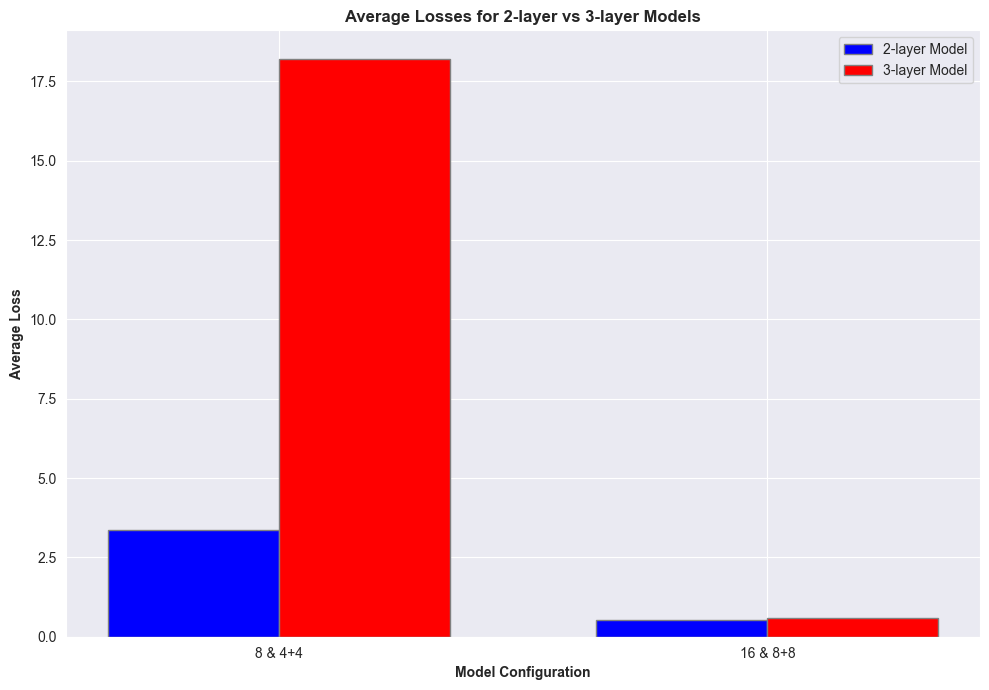

{'8': 3.3534991186420675, '16': 0.5418936200773886} {'4+4': 18.199187450961603, '8+8': 0.5989254062053273}


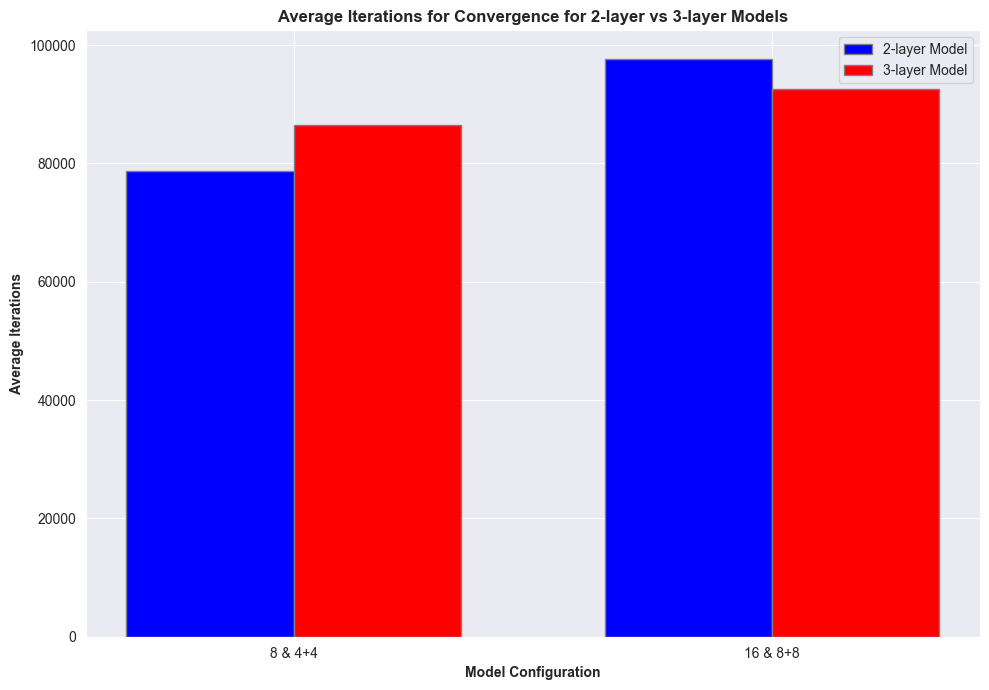

{'8': 78700.6, '16': 97600.1} {'4+4': 86450.45, '8+8': 92650.2}


In [15]:
# Calculate average losses for old and new models for different configurations
avg_losses_old = {config: np.mean(data['losses']) for config, data in results_old.items()}
avg_losses_new = {config: np.mean(data['losses']) for config, data in results_new.items()}

# Bar chart for average loss values
labels = [f"{old_key} & {new_key}" for old_key, new_key in zip(avg_losses_old.keys(), avg_losses_new.keys())]


old_vals = list(avg_losses_old.values())
new_vals = list(avg_losses_new.values())
bar_width = 0.35


r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

print(old_vals, new_vals)

plt.figure(figsize=(10, 7))
plt.bar(r1[:len(old_vals)], old_vals, color='b', width=bar_width, edgecolor='grey', label='2-layer Model')
plt.bar(r2[:len(new_vals)], new_vals, color='r', width=bar_width, edgecolor='grey', label='3-layer Model')

# Title & Subtitle
plt.title('Average Losses for 2-layer vs 3-layer Models', fontweight='bold')
plt.xlabel('Model Configuration', fontweight='bold')
plt.ylabel('Average Loss', fontweight='bold')

# Add xticks on the middle of the group bars
plt.xticks(r1 + 0.5 * bar_width, labels)  # This ensures labels are centered between the old and new model bars

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()

print(avg_losses_old, avg_losses_new)

# Calculate average iterations for old and new models for different configurations
avg_iterations_old = {config: np.mean(data["iterations"]) for config, data in results_old.items()}
avg_iterations_new = {config: np.mean(data["iterations"]) for config, data in results_new.items()}

# Bar chart for average iteration values
old_it_vals = list(avg_iterations_old.values())
new_it_vals = list(avg_iterations_new.values())

r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 7))
plt.bar(r1[:len(old_it_vals)], old_it_vals, color='b', width=bar_width, edgecolor='grey', label='2-layer Model')
plt.bar(r2[:len(new_it_vals)], new_it_vals, color='r', width=bar_width, edgecolor='grey', label='3-layer Model')

# Title & Subtitle
plt.title('Average Iterations for Convergence for 2-layer vs 3-layer Models', fontweight='bold')
plt.xlabel('Model Configuration', fontweight='bold')
plt.ylabel('Average Iterations', fontweight='bold')

# Add xticks on the middle of the group bars
plt.xticks([r + 0.5*bar_width for r in range(len(labels))], labels)

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()
print(avg_iterations_old, avg_iterations_new)


# Discussion

### 
<p>
When we compare the 2-layer model with the 3-layer model, it's evident that the 2-layer model consistently demonstrates superior performance in terms of loss. 

This essentially means that, on average, the 2-layer model's predictions are closer to the actual values than those of the 3-layer model. 

Such a result can be counterintuitive because one might often assume that adding more layers to a neural network, thereby increasing its depth, would inherently lead to improved performance. 

However, in some scenarios, simpler models with fewer layers can capture the underlying patterns in the data more effectively without being susceptible to overfitting. 



When we shift our focus from loss values to the number of iterations required for convergence, the distinction between the two models becomes less clear-cut. 

The iterations to convergence it gives us an idea about the efficiency and speed of the learning process. 

In this case, the difference between the iterations to converge varies only on the number of neurons and not the number of layers.

Specifically, as the number of neurons in the model increases, there is a corresponding increase in the number of iterations required for convergence. 

This seems to suggests that while models with a greater number of neurons have a higher capacity to learn complex patterns and nuances in data, this enhanced capacity comes with the trade-off of potentially longer training times. 

This observation underscores an essential principle in neural network design: increasing model complexity doesn't always lead to faster or better learning. 

Instead, it might introduce challenges in terms of training efficiency and risk of overfitting.

In conclusion, the exploration of these models underscores the multifaceted nature of machine learning model evaluation. 

While the 2-layer model exhibits better loss values, the intricacies of model convergence, especially in relation to model complexity, emphasize the importance of a holistic approach to model assessment and selection.


</p>

# Bonus: arbitrary number of layers (20 points):
Change the functions such that they can accept an arbitrary number of layers, but
keep the overall call-logic and training loops the same - do NOT use classes! For this,
you will need to play around with the dictionaries in create_model, forward,
backprop.


In [16]:
# create a multi-layer neural network
def create_multilayer_model(X, layer_sizes):
    model = {}
    # using ReLU as the default activation function
    model['activation_function'] = 'relu'  

    # Create weights and biases for each layer based on layer_sizes
    for i in range(len(layer_sizes) - 1):
        model[f'W{i+1}'] = np.random.randn(layer_sizes[i], layer_sizes[i+1]) / np.sqrt(layer_sizes[i])
        model[f'b{i+1}'] = np.zeros((1, layer_sizes[i+1]))

    return model

# define the forward pass given a model and data
def feed_forward_multilayer(model, x):
    # get activation function
    act_func = activation_functions.get(model['activation_function'])

    z = {}
    a = {}
    a[0] = x  # the input layer

    # Compute activations and outputs for each layer
    num_layers = len(model) // 2  # for W and b
    for i in range(1, num_layers+1):
        z[i] = a[i-1].dot(model[f'W{i}']) + model[f'b{i}']
        a[i] = act_func(z[i])

    return z, a

# define the regression loss
def calculate_loss_multilayer(model, X, y):
    z, a = feed_forward_multilayer(model, X)
    out = a[len(a) - 1]
    
    # calculate MSE loss
    loss = 0.5 * np.sum((out - y) ** 2)
    # data_loss = np.mean((y - output) ** 2)

    return loss

# back-propagation for the multi-layer network
def backprop_multilayer(X, y, model, z, a):
    m = X.shape[0]
    
    # get activation function derivate
    act_func_derivative = activation_derivatives.get(model['activation_function'])
    num_layers = len(model) // 2  # for W and b

    # Initialize the gradients
    dW = {}
    db = {}
    delta = {}

    # Compute the error for the last layer
    delta[num_layers] = a[num_layers] - y

    # Compute gradients using backpropagation
    for i in reversed(range(1, num_layers+1)):
        dW[i] = a[i-1].T.dot(delta[i]) / m
        db[i] = np.sum(delta[i], axis=0, keepdims=True) / m
        
        if i > 1:  # Skip delta computation for the input layer
            delta[i-1] = delta[i].dot(model[f'W{i}'].T) * act_func_derivative(a[i-1])

    return dW, db

# training loop
def train_multilayer(model, X, y, num_passes=100000, learning_rate=0.001, tolerance=0.0001):
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []
    
    # iteration counter
    i = 0

    while not done:
        # get predictions
        z, a = feed_forward_multilayer(model, X)
        
        # feed this into backprop
        dW, db = backprop_multilayer(X, y, model, z, a)

        # Update weights and biases
        for key in dW:
            model[f'W{key}'] -= learning_rate * dW[key]
            model[f'b{key}'] -= learning_rate * db[key]

        # calculate loss
        loss = calculate_loss_multilayer(model, X, y)

        # print loss per 1000 iterations
        if i % 1000 == 0:
            losses.append(loss)
            print(f"Loss after iteration {i}: {loss}")

            # Check for convergence
            if np.abs((previous_loss - loss) / previous_loss) < tolerance:
                done = True
            previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True

    return model, losses, i

In [17]:
# architectures in lists of layer sizes
architectures = [[2, 8, 1], [2, 4, 4, 1], [2, 16, 1], [2, 8, 8, 1]]

# re-run the model training process with the provided architectures
results = {}

# keeping time
start_time = time.time()

# create and train multiple models with different layer sizes
for arch in architectures:
    model = create_multilayer_model(X, arch)
    trained_model, losses, iterations = train_multilayer(model, X, y, num_passes=10000, learning_rate=0.01, tolerance=0.00001)
    results[str(arch)] = losses
    
    #iterations
    results[str(arch)+'iter'] = iterations

print("--- %s seconds ---" % (time.time() - start_time))

Loss after iteration 0: 215320.92616788292
Loss after iteration 1000: 24781.628623278644


C:\Users\jws\AppData\Local\Temp\ipykernel_20816\4132343458.py:101: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < tolerance:


Loss after iteration 2000: 15036.6445922948
Loss after iteration 3000: 12505.222484740549
Loss after iteration 4000: 9071.066537862675
Loss after iteration 5000: 8353.688396404947
Loss after iteration 6000: 8022.15818954586
Loss after iteration 7000: 7486.8033804344195
Loss after iteration 8000: 7300.194265458081
Loss after iteration 9000: 7146.612527933595
Loss after iteration 0: 279476.3213218919
Loss after iteration 1000: 105564.54864534386
Loss after iteration 2000: 105564.54810495625
Loss after iteration 0: 93314.28999370235
Loss after iteration 1000: 23854.149942046926
Loss after iteration 2000: 11948.252000386288
Loss after iteration 3000: 7206.511238483894
Loss after iteration 4000: 5822.632912972147
Loss after iteration 5000: 5189.13728966589
Loss after iteration 6000: 4620.346557541847
Loss after iteration 7000: 4303.566142865066
Loss after iteration 8000: 4269.70158132828
Loss after iteration 9000: 4305.2852740478265
Loss after iteration 0: 97923.96709973906
Loss after itera

dict_keys(['[2, 8, 1]', '[2, 8, 1]iter', '[2, 4, 4, 1]', '[2, 4, 4, 1]iter', '[2, 16, 1]', '[2, 16, 1]iter', '[2, 8, 8, 1]', '[2, 8, 8, 1]iter'])


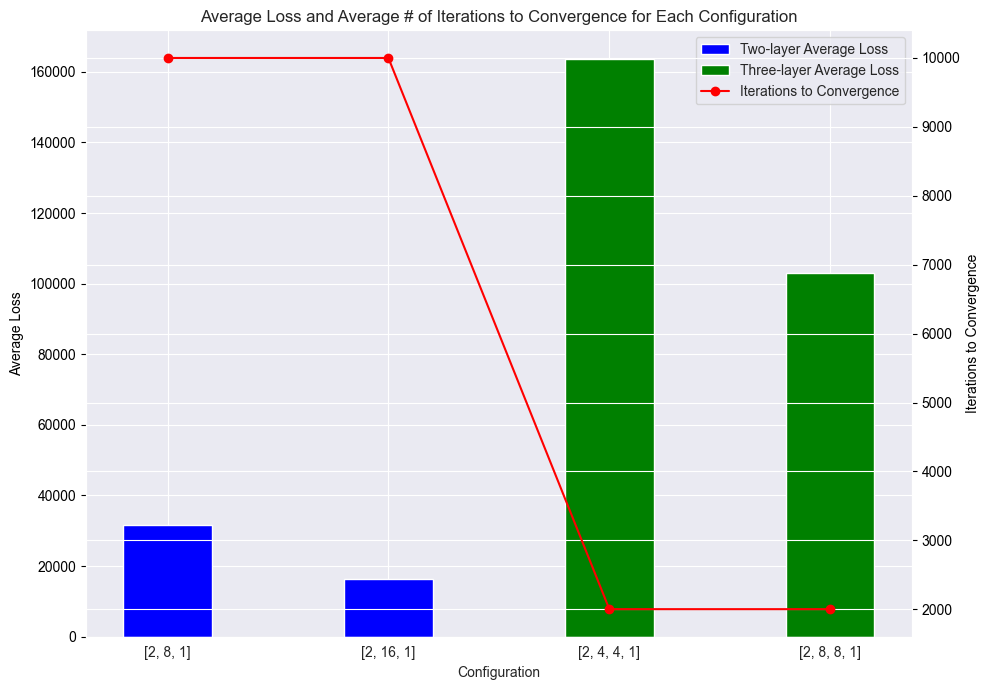

In [18]:
# Extracting data for plotting
print(results.keys())

configs_two_layer = ['[2, 8, 1]', '[2, 16, 1]']
configs_three_layer = ['[2, 4, 4, 1]', '[2, 8, 8, 1]']

# Compute Average losses
average_losses_two_layer = [np.mean(results[config]) for config in configs_two_layer]
average_losses_three_layer = [np.mean(results[config]) for config in configs_three_layer]

iterations_of_convergence_two_layer = [np.mean(results[config+'iter']) for config in configs_two_layer]
iterations_of_convergence_three_layer = [np.mean(results[config+'iter']) for config in configs_three_layer]

# Create the combined bar + line graph
fig, ax1 = plt.subplots(figsize=(10, 7))

# Combine the results
configs_combined = configs_two_layer + configs_three_layer
median_losses_combined = average_losses_two_layer + average_losses_three_layer
iterations_of_convergence_combined = iterations_of_convergence_two_layer + iterations_of_convergence_three_layer

# Bar graph for Average Loss
bars = ax1.bar(configs_combined, median_losses_combined,
               color=['blue', 'blue', 'green', 'green'],
               width=0.4, align='center')
ax1.set_title('Average Loss and Average # of Iterations to Convergence for Each Configuration')
ax1.set_xlabel('Configuration')
ax1.set_ylabel('Average Loss', color='black')
ax1.tick_params('y', colors='black')

# Line graph for Iterations using twin axes
ax2 = ax1.twinx()
line, = ax2.plot(configs_combined, iterations_of_convergence_combined, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Iterations to Convergence', color='black')
ax2.tick_params('y', colors='black')

# Legend
ax1.legend([bars[0], bars[2], line], ["Two-layer Average Loss", "Three-layer Average Loss", "Iterations to Convergence"], loc='upper right')

plt.tight_layout()
plt.show()

# print(iterations_of_convergence_combined)
# print(median_losses_combined)

# Part2 Pytorch version (20 points):

<p>
Add all code to the same threelayer.ipynb.
Given that everything is easier with pytorch, adapt the code from class to solve the
exact same regression problem with three layers and the same number of
parameters. Use the ‘“nn” layers. Visualize the network architecture as well.
Test the network 20 times with ADAM optimizer and 20 times with SGD optimizer,
using a suitably high number of iterations. Record, plot, and compare the loss
evaluation of the two optimizer runs. What can you say about the optimizers?
</p>

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

In [20]:
def train_model_pytorch(model, X, y, optimizer_type='adam', num_epochs=10000, lr=0.001):
    criterion = nn.MSELoss()  # Mean Squared Error Loss

    # Choose the optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Convert data to torch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Training loop
    losses = []
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss
        losses.append(loss.item())

        # Print every 1000 epochs
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return losses

In [21]:
# Train the models with the new data using nn.Sequential
losses_adam_seq = []
losses_sgd_seq = []
input_dim = X.shape[1]
hidden_nodes = [8, 8]
output_dim = 1

# keeping time
start_time = time.time()

for _ in range(20):
    # build model with adam optimizer
    model_adam_seq = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes[0]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[0], hidden_nodes[1]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[1], output_dim)
    )
    losses_adam_seq.append(train_model_pytorch(model_adam_seq, X, y, optimizer_type='adam', num_epochs=10000, lr=0.001))

    # build model with sgd optimizer
    model_sgd_seq = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes[0]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[0], hidden_nodes[1]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[1], output_dim)
    )
    losses_sgd_seq.append(train_model_pytorch(model_sgd_seq, X, y, optimizer_type='sgd', num_epochs=10000, lr=0.001))

    print(f'difference of optimizers: {losses_sgd_seq[-1][-1] - losses_adam_seq[-1][-1]}')
    print(f'Done with run {_}')


print("--- %s seconds ---" % (time.time() - start_time))

Epoch [1000/10000], Loss: 192.4335
Epoch [2000/10000], Loss: 96.9576
Epoch [3000/10000], Loss: 39.4108
Epoch [4000/10000], Loss: 21.6837
Epoch [5000/10000], Loss: 13.1703
Epoch [6000/10000], Loss: 9.3041
Epoch [7000/10000], Loss: 6.8145
Epoch [8000/10000], Loss: 4.8742
Epoch [9000/10000], Loss: 3.8784
Epoch [10000/10000], Loss: 3.4342
Epoch [1000/10000], Loss: 146.3619
Epoch [2000/10000], Loss: 44.6248
Epoch [3000/10000], Loss: 17.7828
Epoch [4000/10000], Loss: 13.1166
Epoch [5000/10000], Loss: 13.1765
Epoch [6000/10000], Loss: 11.6305
Epoch [7000/10000], Loss: 9.4988
Epoch [8000/10000], Loss: 9.6435
Epoch [9000/10000], Loss: 9.5128
Epoch [10000/10000], Loss: 8.5256
difference of optimizers: 5.091455459594727
Done with run 0
Epoch [1000/10000], Loss: 199.2941
Epoch [2000/10000], Loss: 101.8423
Epoch [3000/10000], Loss: 39.9074
Epoch [4000/10000], Loss: 23.8457
Epoch [5000/10000], Loss: 20.1718
Epoch [6000/10000], Loss: 17.8953
Epoch [7000/10000], Loss: 13.6703
Epoch [8000/10000], Loss:

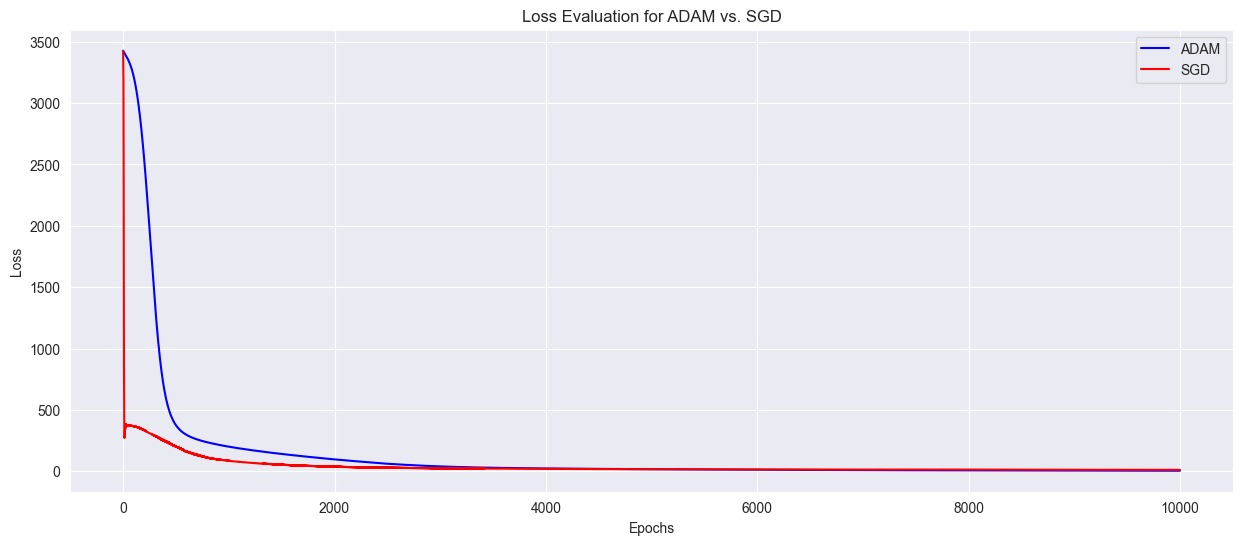

In [22]:
# Plot the loss evaluations for ADAM and SGD optimizers using the provided models
plt.figure(figsize=(15, 6))

# Average loss for better visualization
avg_losses_adam_seq = np.mean(losses_adam_seq, axis=0)
avg_losses_sgd_seq = np.mean(losses_sgd_seq, axis=0)

plt.plot(avg_losses_adam_seq, label='ADAM', color='blue')
plt.plot(avg_losses_sgd_seq, label='SGD', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evaluation for ADAM vs. SGD')
plt.legend()
plt.grid(True)
plt.show()

# Discussion

<p>
SGD’s Better Performance in this Specific Task:

The graph suggests that SGD is performing better because the dataset is relatively small, and the model is not complex. SGD can be more effective in such scenarios because it may generalize better, avoiding overfitting which is a common concern in small datasets. In contrast, Adam, with its adaptive learning rates, might overfit or converge too quickly to suboptimal solutions in such settings.

 Adam is known for its efficiency in handling large datasets and its effectiveness in training complex models. It does this by adapting the learning rate for each parameter, which helps in navigating through the parameter space more efficiently, especially when dealing with sparse gradients or non-stationary objectives.
Fast Convergence and Adaptability: Adam generally converges faster than traditional SGD because of its adaptive learning rate mechanism. This can be particularly beneficial when training deep networks or dealing with challenging optimization landscapes.

In simpler scenarios or with smaller datasets, SGD's straightforward approach to optimization can sometimes lead to finding better (or more generalized) solutions. Since Adam adjusts learning rates based on recent gradient updates, it might miss certain nuances that a more steady, consistent update rule like SGD captures.
Learning Rate, Noise, Regularization Factors: These factors can also influence the performance of the optimizers. For example, the inherent noise in SGD updates can help escape local minima, potentially leading to better solutions in some landscapes. Regularization factors might also interact differently with these optimizers, affecting their performance.

While Adam is often a preferred choice for many deep learning tasks, it’s not universally superior. The choice of optimizer and its tuning should depend on the specific characteristics of the problem at hand.
This emphasizes the importance of empirical testing and validation in choosing an optimizer. Different problems might benefit from different optimizers, and the best way to determine the right choice is often through experimentation and performance evaluations.
</p>
